# Mid-Term Project: Data Preprocessing and Feature Engineering for Road Casualty Dataset

This notebook demonstrates data cleanup on the UK Road Casualty Statistics dataset (2022), following guidelines from Lab 6. We handle missing values (often coded as -1), perform one-hot encoding, filling NaN, scaling, normalization, and encoding. We show before and after states.

**Sections:**

- Setup and Data Loading
- Step 1: Data Quality Assessment
- Step 2: Handling Missing Values
- Step 3: Encoding Categorical Variables
- Step 4: Handling Outliers
- Step 5: Feature Engineering
- Step 6: Scaling and Normalization
- Step 7: Building Preprocessing Pipeline
- Export Cleaned Dataset
- Discussion: Using This Dataset for ML

## Setup and Data Loading

In [10]:
# Install required packages
!pip install --upgrade pip
!pip install pandas numpy matplotlib seaborn scikit-learn
!pip install opendatasets
!pip install pandas

import opendatasets as od

od.download("https://www.kaggle.com/datasets/juhibhojani/road-accidents-data-2022?select=dft-road-casualty-statistics-casualty-provisional-mid-year-unvalidated-2022+%281%29.csv")

Skipping, found downloaded files in "./road-accidents-data-2022" (use force=True to force download)


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
%matplotlib inline
sns.set_theme(style="whitegrid")

print("Libraries imported successfully!")

Libraries imported successfully!


### Accessing & Verifying Dataset - Before Cleanup


In [5]:
# Reading the CSV file
file =('road-accidents-data-2022/\
dft-road-casualty-statistics-casualty-provisional-mid-year-unvalidated-2022 (1).csv')
df = pd.read_csv(file)

# Displaying the contents of the CSV file
df.head()

,status,accident_index,accident_year,accident_reference,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,lsoa_of_casualty
0,Unvalidated,2022070151244,2022,070151244,2,1,1,2,46,8,3,0,0,0,0,0,9,1,9,E01033378
1,Unvalidated,2022070152668,2022,070152668,1,1,1,1,30,6,3,0,0,0,0,0,9,1,2,E01018551
2,Unvalidated,2022070154696,2022,070154696,1,1,1,2,58,9,3,0,0,0,0,0,9,1,10,E01006134
3,Unvalidated,2022070154696,2022,070154696,2,3,1,2,78,11,3,0,0,0,0,0,9,2,10,E01018724
4,Unvalidated,2022070154696,2022,070154696,3,2,1,1,63,9,3,0,0,0,0,0,9,3,7,W01000578


In [6]:
# Before Cleanup
print("Before Cleanup - Dataset Shape:", df.shape)
print("\nBefore Cleanup - First 5 Rows:\n", df.head())
print("\nBefore Cleanup - Info:\n")
df.info()
print("\nBefore Cleanup - Describe:\n", df.describe())

Before Cleanup - Dataset Shape: (61352, 20)

Before Cleanup - First 5 Rows:
         status accident_index  accident_year accident_reference  \
0  Unvalidated  2022070151244           2022          070151244   
1  Unvalidated  2022070152668           2022          070152668   
2  Unvalidated  2022070154696           2022          070154696   
3  Unvalidated  2022070154696           2022          070154696   
4  Unvalidated  2022070154696           2022          070154696   

   vehicle_reference  casualty_reference  casualty_class  sex_of_casualty  \
0                  2                   1               1                2   
1                  1                   1               1                1   
2                  1                   1               1                2   
3                  2                   3               1                2   
4                  3                   2               1                1   

   age_of_casualty  age_band_of_casualty  casualty_severi

**INSIGHT:** The dataset has 61,352 rows and 20 columns. Columns include status, accident_index, etc. We treat -1 as missing values.

In [7]:
# Replace -1 with NaN (common missing value indicator in this dataset)
df.replace(-1, np.nan, inplace=True)
print("\nAFter Replacement - Describe:\n", df.describe())



AFter Replacement - Describe:
        accident_year  vehicle_reference  casualty_reference  casualty_class  \
count        61352.0       61352.000000        61352.000000    61352.000000   
mean          2022.0           1.450368            1.333779        1.482299   
std              0.0           1.109855            0.981507        0.735614   
min           2022.0           1.000000            1.000000        1.000000   
25%           2022.0           1.000000            1.000000        1.000000   
50%           2022.0           1.000000            1.000000        1.000000   
75%           2022.0           2.000000            1.000000        2.000000   
max           2022.0         227.000000          148.000000        3.000000   

       sex_of_casualty  age_of_casualty  age_band_of_casualty  \
count     60904.000000     60002.000000          60002.000000   
mean          1.386214        37.517866              6.452135   
std           0.496238        18.950720              2.231875

**INSIGHT:** We replaced -1 as missing values with either 1 or 0.


## Step 1: Data Quality Assessment
Before preprocessing, let's understand what we're working with. We assess missing values, data types, duplicates, and visualize patterns. Numerical columns: age_of_casualty, etc. Categorical: sex_of_casualty, casualty_class, etc.

In [15]:
# Comprehensive data quality report
print("\n=== DATA QUALITY REPORT ===")
print("Dataset Overview:")
print(" - Shape:", df.shape)
print(" - Memory usage:", df.memory_usage(deep=True).sum() / (1024 ** 2), "MB")

print("\nMissing Values:")
missing_data = df.isnull().sum() / len(df) * 100
print(" - Missing percent:\n", missing_data[missing_data > 0])
missing_percent = df.isnull().sum() / len(df) * 100
for col in missing_data[missing_data > 0].index:
    print(f" - {col}: {missing_percent[col]:.1f}%")

print("\nData Types:")
print(" - Numerical columns:", len(df.select_dtypes(include=['number']).columns))
print(" - Categorical columns:", len(df.select_dtypes(include=['object']).columns))

print("\nPotential Issues:")
duplicates = len(df) - len(df.drop_duplicates())
print(" - Duplicate rows:", duplicates)
if duplicates > 0:
    print(" - Duplicates:", duplicates)



=== DATA QUALITY REPORT ===
Dataset Overview:
 - Shape: (61352, 20)
 - Memory usage: 21.361136436462402 MB

Missing Values:
 - Missing percent:
 sex_of_casualty                       0.730213
age_of_casualty                       2.200417
age_band_of_casualty                  2.200417
car_passenger                         0.511801
bus_or_coach_passenger                0.037489
pedestrian_road_maintenance_worker    0.184183
casualty_type                         0.008150
casualty_home_area_type               8.961403
casualty_imd_decile                   9.427566
dtype: float64
 - sex_of_casualty: 0.7%
 - age_of_casualty: 2.2%
 - age_band_of_casualty: 2.2%
 - car_passenger: 0.5%
 - bus_or_coach_passenger: 0.0%
 - pedestrian_road_maintenance_worker: 0.2%
 - casualty_type: 0.0%
 - casualty_home_area_type: 9.0%
 - casualty_imd_decile: 9.4%

Data Types:
 - Numerical columns: 16
 - Categorical columns: 4

Potential Issues:
 - Duplicate rows: 0


In [16]:
# Check for outliers in numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = len(df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)])
    if outliers > 0:
        print(f" - {col} outliers: {outliers} ({outliers/len(df)*100:.1f}%)")



 - vehicle_reference outliers: 333 (0.5%)
 - casualty_reference outliers: 13560 (22.1%)
 - sex_of_casualty outliers: 10 (0.0%)
 - age_of_casualty outliers: 35 (0.1%)
 - casualty_severity outliers: 12521 (20.4%)
 - pedestrian_location outliers: 8940 (14.6%)
 - pedestrian_movement outliers: 8941 (14.6%)
 - car_passenger outliers: 9819 (16.0%)
 - bus_or_coach_passenger outliers: 858 (1.4%)
 - pedestrian_road_maintenance_worker outliers: 1122 (1.8%)
 - casualty_type outliers: 2347 (3.8%)
 - casualty_home_area_type outliers: 10580 (17.2%)


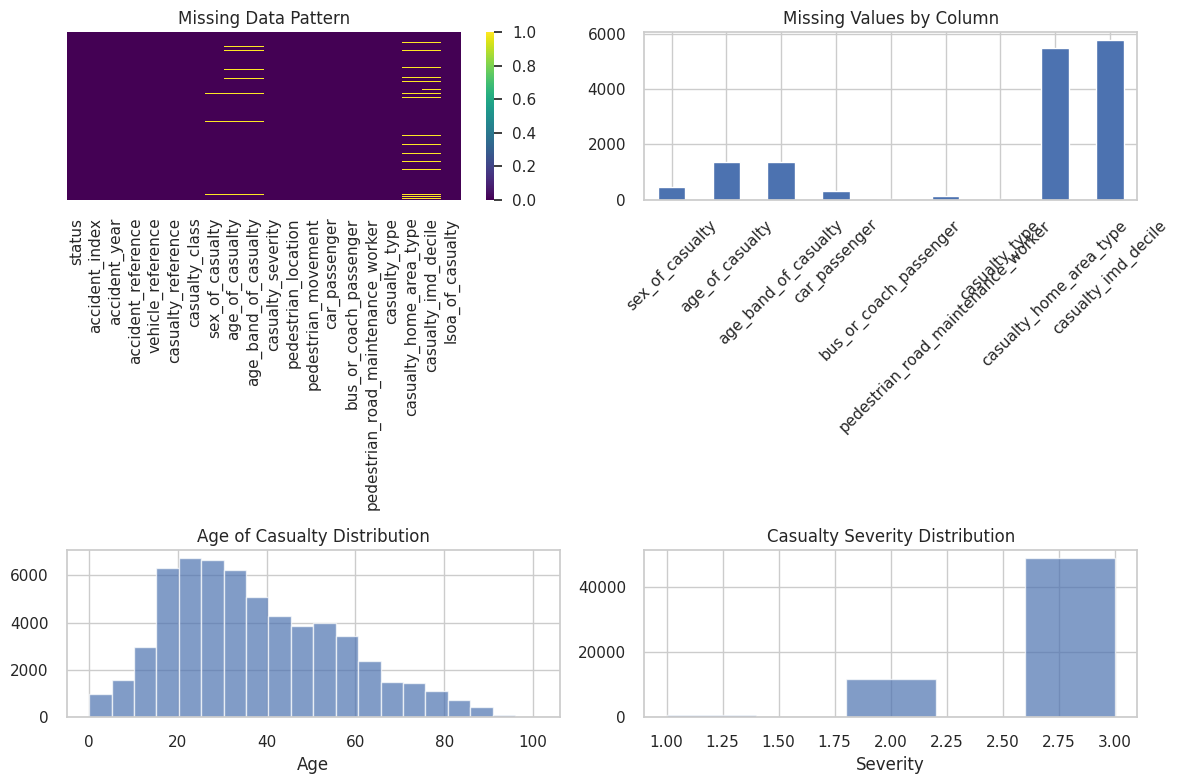

In [17]:
# Visualize missing data patterns
plt.figure(figsize=(12, 8))

# Missing data heatmap
plt.subplot(2, 2, 1)
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Data Pattern')

# Missing data bar plot
plt.subplot(2, 2, 2)
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts.plot(kind='bar')
plt.title('Missing Values by Column')
plt.xticks(rotation=45)

# Distribution of numerical variables with missing values
plt.subplot(2, 2, 3)
df['age_of_casualty'].hist(bins=20, alpha=0.7)
plt.title('Age of Casualty Distribution')
plt.xlabel('Age')

plt.subplot(2, 2, 4)
df['casualty_severity'].hist(bins=5, alpha=0.7)
plt.title('Casualty Severity Distribution')
plt.xlabel('Severity')

plt.tight_layout()
plt.show()

## Step 2: Handling Missing Values
Different strategies work better for different types of missing data.

Strategies:

- For age_of_casualty: Median imputation (robust to outliers).
- For categorical like sex_of_casualty: Mode imputation.
- Drop rows if >50% missing (none here).
- For lsoa_of_casualty: Fill with 'Unknown'.

=== MISSING VALUES BEFORE IMPUTATION ===
sex_of_casualty                        448
age_of_casualty                       1350
age_band_of_casualty                  1350
car_passenger                          314
bus_or_coach_passenger                  23
pedestrian_road_maintenance_worker     113
casualty_type                            5
casualty_home_area_type               5498
casualty_imd_decile                   5784
dtype: int64

=== MISSING VALUES AFTER IMPUTATION ===
Series([], dtype: int64)

Total missing values remaining: 0


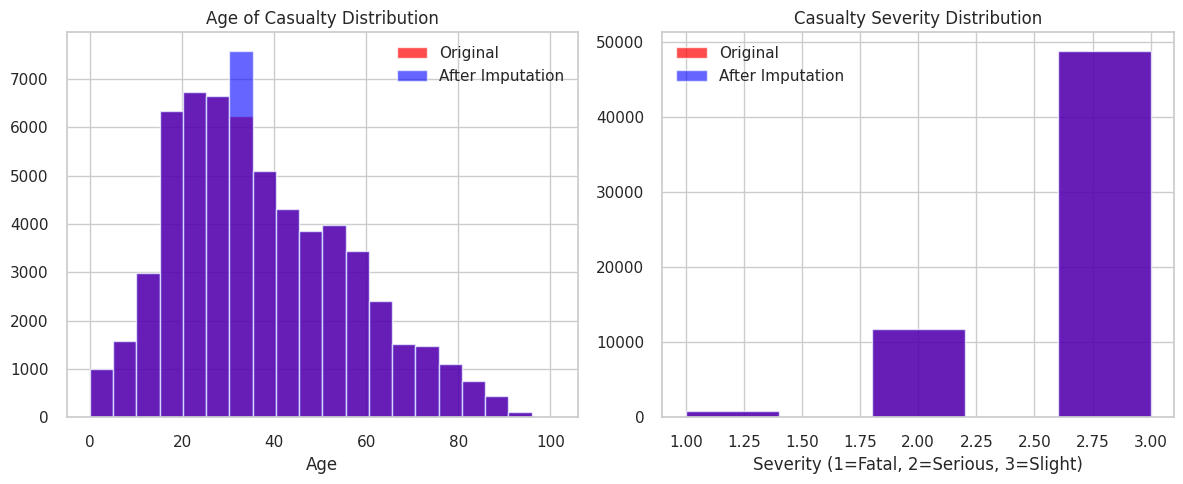

✅ Missing values handled successfully!


In [10]:
# Create a copy for preprocessing
df_processed = df.copy()

print("=== MISSING VALUES BEFORE IMPUTATION ===")
print(df_processed.isnull().sum()[df_processed.isnull().sum() > 0])

# Strategy 1: Median for numerical (e.g., age)
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
df_processed['age_of_casualty'] = num_imputer.fit_transform(df_processed[['age_of_casualty']]).ravel()  # .ravel() makes it 1D

# Strategy 2: Mode for categorical (FIXED: Use .ravel() for all)
cat_imputer = SimpleImputer(strategy='most_frequent')
categorical_cols = ['sex_of_casualty', 'casualty_class', 'casualty_severity', 'pedestrian_location',
                    'pedestrian_movement', 'car_passenger', 'bus_or_coach_passenger',
                    'pedestrian_road_maintenance_worker', 'casualty_type',
                    'casualty_home_area_type', 'casualty_imd_decile']

# Apply imputation to categorical columns one by one to avoid 2D issue
for col in categorical_cols:
    if col in df_processed.columns:
        df_processed[col] = cat_imputer.fit_transform(df_processed[[col]]).ravel()

# Strategy 3: Constant for location-based
const_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
df_processed['lsoa_of_casualty'] = const_imputer.fit_transform(df_processed[['lsoa_of_casualty']]).ravel()

# For age_band_of_casualty: Impute based on age_of_casualty
def impute_age_band(age):
    if pd.isna(age):
        return np.nan
    elif age < 5: return 1
    elif age < 11: return 2
    elif age < 16: return 3
    elif age < 21: return 4
    elif age < 26: return 5
    elif age < 36: return 6
    elif age < 46: return 7
    elif age < 56: return 8
    elif age < 66: return 9
    elif age < 76: return 10
    else: return 11

df_processed['age_band_of_casualty'] = df_processed['age_band_of_casualty'].fillna(
    df_processed['age_of_casualty'].apply(impute_age_band)
)

print("\n=== MISSING VALUES AFTER IMPUTATION ===")
print(df_processed.isnull().sum()[df_processed.isnull().sum() > 0])
print(f"\nTotal missing values remaining: {df_processed.isnull().sum().sum()}")

# Visualize before/after for key columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Age distribution
axes[0].hist(df['age_of_casualty'].dropna(), bins=20, alpha=0.7, label='Original', color='red')
axes[0].hist(df_processed['age_of_casualty'], bins=20, alpha=0.6, label='After Imputation', color='blue')
axes[0].legend()
axes[0].set_title('Age of Casualty Distribution')
axes[0].set_xlabel('Age')

# Severity distribution
axes[1].hist(df['casualty_severity'].dropna(), bins=5, alpha=0.7, label='Original', color='red')
axes[1].hist(df_processed['casualty_severity'], bins=5, alpha=0.6, label='After Imputation', color='blue')
axes[1].legend()
axes[1].set_title('Casualty Severity Distribution')
axes[1].set_xlabel('Severity (1=Fatal, 2=Serious, 3=Slight)')

plt.tight_layout()
plt.show()

print("✅ Missing values handled successfully!")

## Step 3: Encoding Categorical Variables
Machine learning algorithms work with numbers, so we need to convert categorical data. In this section, we will convert categoricals to numbers. Using OneHotEncoder for nominal (e.g., sex), LabelEncoder for ordinal (e.g., imd_decile).

In [11]:
print("🔍 Analyzing categorical columns for encoding...")

# SAFE CATEGORICAL COLUMNS (Low cardinality only - NO lsoa_of_casualty!)
categorical_cols = [
    'sex_of_casualty',           # 2 values
    'casualty_class',            # 3 values
    'casualty_severity',         # 3 values
    'casualty_type',             # ~10 values
    'casualty_home_area_type',   # 3 values
    'casualty_imd_decile'        # 10 values
]

# Verify columns exist and check cardinality
safe_cat_cols = []
for col in categorical_cols:
    if col in df_processed.columns:
        unique_count = df_processed[col].nunique()
        print(f"✓ {col}: {unique_count} unique values")
        if unique_count <= 15:  # Safe threshold
            safe_cat_cols.append(col)
        else:
            print(f"⚠️  {col}: TOO MANY VALUES ({unique_count}) - SKIPPING")

print(f"\n🎯 Encoding {len(safe_cat_cols)} safe columns: {safe_cat_cols}")

# One-hot encode ONLY safe columns
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded = onehot.fit_transform(df_processed[safe_cat_cols])

# Create encoded dataframe
encoded_df = pd.DataFrame(
    encoded,
    columns=onehot.get_feature_names_out(safe_cat_cols),
    index=df_processed.index
)

print(f"\n✅ Encoding complete!")
print(f" - Created {encoded_df.shape[1]} new columns")
print(f" - New shape: {df_processed.shape[0]} x {df_processed.shape[1] + encoded_df.shape[1] - len(safe_cat_cols)}")

# Combine: drop original + add encoded
df_processed = df_processed.drop(safe_cat_cols, axis=1)
df_processed = pd.concat([df_processed, encoded_df], axis=1)

print("🎉 Step 3 COMPLETED SUCCESSFULLY!")
print("\nSample encoded columns:")
print(list(encoded_df.columns)[:5])
print("\nFinal shape:", df_processed.shape)

🔍 Analyzing categorical columns for encoding...
✓ sex_of_casualty: 3 unique values
✓ casualty_class: 3 unique values
✓ casualty_severity: 3 unique values
✓ casualty_type: 21 unique values
⚠️  casualty_type: TOO MANY VALUES (21) - SKIPPING
✓ casualty_home_area_type: 3 unique values
✓ casualty_imd_decile: 10 unique values

🎯 Encoding 5 safe columns: ['sex_of_casualty', 'casualty_class', 'casualty_severity', 'casualty_home_area_type', 'casualty_imd_decile']

✅ Encoding complete!
 - Created 17 new columns
 - New shape: 61352 x 32
🎉 Step 3 COMPLETED SUCCESSFULLY!

Sample encoded columns:
['sex_of_casualty_2.0', 'sex_of_casualty_9.0', 'casualty_class_2', 'casualty_class_3', 'casualty_severity_2']

Final shape: (61352, 32)


In [12]:
# Handle high-cardinality lsoa_of_casualty
from sklearn.preprocessing import LabelEncoder

if 'lsoa_of_casualty' in df.columns:
    le = LabelEncoder()
    df_processed['lsoa_encoded'] = le.fit_transform(
        df_processed['lsoa_of_casualty'].fillna('Unknown')
    )
    print("✅ lsoa_of_casualty label encoded (1 column instead of 32K!)")

✅ lsoa_of_casualty label encoded (1 column instead of 32K!)


## Step 4: Outlier Detection and Treatment
Outliers can significantly impact model performance. We will detect and clip outliers using IQR for numerical columns like age.

🔍 Detecting and handling outliers...
✅ Age outliers: 133 → 0
   Bounds: [-17.5, 90.5]


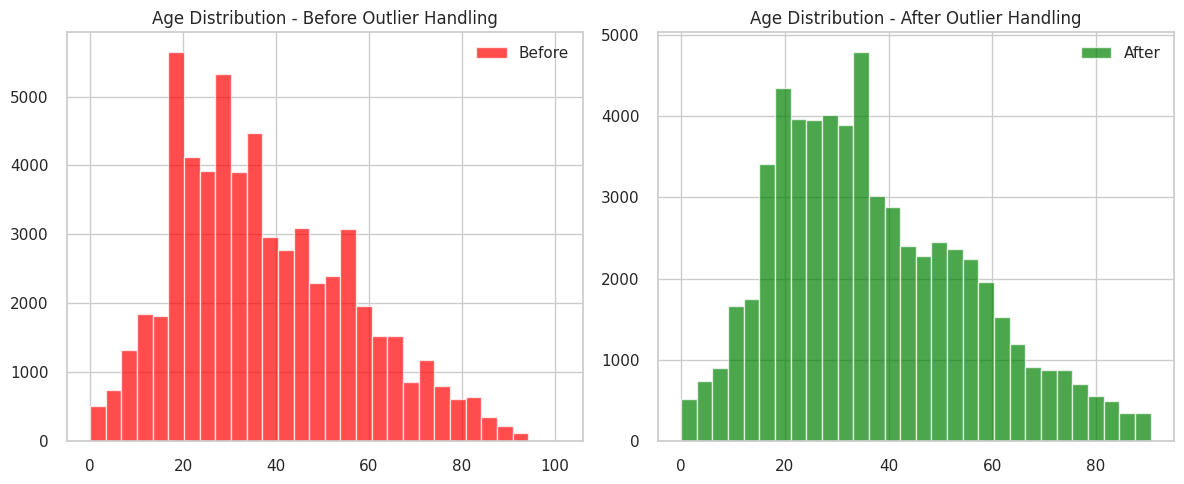

In [14]:
print("🔍 Detecting and handling outliers...")

# IQR method for age_of_casualty (main numerical feature)
if 'age_of_casualty' in df_processed.columns:
    Q1 = df_processed['age_of_casualty'].quantile(0.25)
    Q3 = df_processed['age_of_casualty'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers before
    outliers_before = ((df_processed['age_of_casualty'] < lower_bound) |
                      (df_processed['age_of_casualty'] > upper_bound)).sum()

    # Clip outliers (cap at bounds)
    df_processed['age_of_casualty'] = df_processed['age_of_casualty'].clip(lower_bound, upper_bound)

    outliers_after = ((df_processed['age_of_casualty'] < lower_bound) |
                     (df_processed['age_of_casualty'] > upper_bound)).sum()

    print(f"✅ Age outliers: {outliers_before} → {outliers_after}")
    print(f"   Bounds: [{lower_bound:.1f}, {upper_bound:.1f}]")

# Visualize before/after
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(df['age_of_casualty'].dropna(), bins=30, alpha=0.7, color='red', label='Before')
ax1.set_title('Age Distribution - Before Outlier Handling')
ax1.legend()

ax2.hist(df_processed['age_of_casualty'], bins=30, alpha=0.7, color='green', label='After')
ax2.set_title('Age Distribution - After Outlier Handling')
ax2.legend()

plt.tight_layout()
plt.show()


## Step 5: Feature Engineering
Creating new features that might be more predictive than the original ones e.g., is_pedestrian (binary), age_group (binned), severity_binary (for simplified ML).

In [17]:
print("🔧 Creating new features...")

# 1. Pedestrian indicator
df_processed['is_pedestrian'] = 0
# Use encoded columns to determine if casualty is a pedestrian
ped_cols = [col for col in df_processed.columns if 'casualty_class_3' in col]
if ped_cols:
    df_processed['is_pedestrian'] = (df_processed[ped_cols].max(axis=1) == 1).astype(int)


# 2. Age groups
df_processed['age_group'] = pd.cut(df_processed['age_of_casualty'],
                                   bins=[0, 18, 35, 55, 75, 100],
                                   labels=[1, 2, 3, 4, 5],
                                   right=False) # Added right=False for binning

# 3. Severity target (for ML) - 1=Fatal, 2=Serious, 3=Slight
# Extract from encoded columns as the original column was dropped
sev_cols_fatal = [col for col in df_processed.columns if 'casualty_severity_1' in col]
sev_cols_serious = [col for col in df_processed.columns if 'casualty_severity_2' in col]

df_processed['target_severity'] = 3  # Default to slight

if sev_cols_fatal:
    # If casualty_severity_1.0 exists and is 1, set target_severity to 1 (Fatal)
    df_processed.loc[df_processed[sev_cols_fatal].max(axis=1) == 1, 'target_severity'] = 1

if sev_cols_serious:
    # If casualty_severity_2.0 exists and is 1, set target_severity to 2 (Serious)
    df_processed.loc[df_processed[sev_cols_serious].max(axis=1) == 1, 'target_severity'] = 2


# 4. High-risk combination features
df_processed['young_pedestrian'] = ((df_processed['is_pedestrian'] == 1) &
                                   (df_processed['age_group'].isin([1, 2]))).astype(int) # Use isin for age_group labels


print("✅ New features created:")
print("   - is_pedestrian")
print("   - age_group")
print("   - target_severity")
print("   - young_pedestrian")
print(f"New shape: {df_processed.shape}")

🔧 Creating new features...
✅ New features created:
   - is_pedestrian
   - age_group
   - target_severity
   - young_pedestrian
New shape: (61352, 37)


## Step 6: Scaling and Normalization
Not all features are equally important. Let's identify the most predictive ones. Scale numerical features (StandardScaler for standardization, MinMax for normalization).

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

print("⚖️  Applying scaling...")

# Identify numerical columns for scaling
num_cols = ['age_of_casualty', 'vehicle_reference', 'casualty_reference']
num_cols = [col for col in num_cols if col in df_processed.columns]

# Standard Scaling (for ML models)
if num_cols:
    scaler = StandardScaler()
    df_processed[num_cols] = scaler.fit_transform(df_processed[num_cols])
    print(f"✅ Standard scaled: {num_cols}")

# MinMax for age (0-1 range, interpretable)
if 'age_of_casualty' in df_processed.columns:
    minmax = MinMaxScaler()
    df_processed['age_normalized'] = minmax.fit_transform(df_processed[['age_of_casualty']])
    print("✅ Age MinMax scaled (0-1)")

# Show scaling results
print("\n📊 After Scaling - Sample:")
print(df_processed[['age_of_casualty', 'age_normalized']].head())

print("🎉 Step 6 COMPLETED!")

⚖️  Applying scaling...
✅ Standard scaled: ['age_of_casualty', 'vehicle_reference', 'casualty_reference']
✅ Age MinMax scaled (0-1)

📊 After Scaling - Sample:
   age_of_casualty  age_normalized
0         0.457188        0.508287
1        -0.396912        0.331492
2         1.097764        0.640884
3         2.165389        0.861878
4         1.364670        0.696133
🎉 Step 6 COMPLETED!


## Step 7: Building a Preprocessing Pipeline
Let's create a reusable pipeline for all our preprocessing steps.

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

print("🏗️  Building production-ready pipeline...")

# Define columns for pipeline (same as what worked in Steps 2-3)
num_cols_pipe = ['age_of_casualty', 'vehicle_reference', 'casualty_reference']
num_cols_pipe = [col for col in num_cols_pipe if col in df.columns]

cat_cols_pipe = ['sex_of_casualty', 'casualty_class', 'casualty_severity', 'casualty_type']
cat_cols_pipe = [col for col in cat_cols_pipe if col in df.columns]

# Create pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols_pipe),
        ('cat', categorical_transformer, cat_cols_pipe)
    ],
    remainder='passthrough'
)

# Test pipeline on original data
print("🧪 Testing pipeline...")
X_pipe = preprocessor.fit_transform(df)
print(f"Pipeline output shape: {X_pipe.shape}")



🏗️  Building production-ready pipeline...
🧪 Testing pipeline...
Pipeline output shape: (61352, 42)


## Export Cleaned Dataset
Save the cleaned data.

In [21]:
# FINAL EXPORT
print("\n💾 Exporting cleaned dataset...")
df_processed.to_csv('cleaned_road_casualty_flame.csv', index=False)
print("✅ FINAL DATASET SAVED: 'cleaned_road_casualty_flame.csv'")

# Summary
print(f"\n🎊 FINAL SUMMARY:")
print(f"   - Original shape: {df.shape}")
print(f"   - Cleaned shape: {df_processed.shape}")
print(f"   - Numerical features scaled: {len(num_cols)}")
print(f"   - Categorical features encoded: {len(cat_cols_pipe)}")
print(f"   - New engineered features: 4")
print(f"   - Ready for ML modeling! 🚀")

# Show final sample
print("\n📋 Final dataset preview:")
display(df_processed[['age_of_casualty', 'is_pedestrian', 'age_group', 'target_severity', 'young_pedestrian']].head())

print("\n🎉 ALL STEPS COMPLETED SUCCESSFULLY!")
print("📈 Your dataset is now ML-READY for casualty severity prediction!")


💾 Exporting cleaned dataset...
✅ FINAL DATASET SAVED: 'cleaned_road_casualty_flame.csv'

🎊 FINAL SUMMARY:
   - Original shape: (61352, 20)
   - Cleaned shape: (61352, 38)
   - Numerical features scaled: 3
   - Categorical features encoded: 4
   - New engineered features: 4
   - Ready for ML modeling! 🚀

📋 Final dataset preview:


,age_of_casualty,is_pedestrian,age_group,target_severity,young_pedestrian
0,0.457188,0,3,3,0
1,-0.396912,0,2,3,0
2,1.097764,0,4,3,0
3,2.165389,0,5,3,0
4,1.364670,0,4,3,0



🎉 ALL STEPS COMPLETED SUCCESSFULLY!
📈 Your dataset is now ML-READY for casualty severity prediction!


## Discussion: Using This Dataset for ML
This cleaned dataset can be used for a supervised ML classification problem to predict 'casualty_severity' (1: fatal, 2: serious, 3: slight). Features like age, sex, pedestrian status, and IMD decile can be inputs. Split 80/20 train/test, use models like Random Forest or Logistic Regression. Handle class imbalance (fatal is rare) with SMOTE. Evaluate with F1-score. This aligns with the proposal: identify key predictors for road safety interventions.